In [14]:
# === 1. 環境設定 ===
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# === 2. 建立 2D grid & 可解析函數場 ===
H, W = 64, 64
x = torch.linspace(0, 2*np.pi, W, device=device)
y = torch.linspace(0, 2*np.pi, H, device=device)
X, Y = torch.meshgrid(x, y, indexing='ij')
X.requires_grad_(True)
Y.requires_grad_(True)

# f(x, y)
f = torch.sin(X) * torch.cos(Y)

# === 3. 一次性計算 autograd 導數 ===
df_dx, df_dy = torch.autograd.grad(f.sum(), (X, Y), create_graph=False)

# === 4. detach 所有 tensor ===
f_tensor = f.detach().unsqueeze(0).unsqueeze(0)           # (1,1,H,W)
df_dx_const = df_dx.detach().unsqueeze(0).unsqueeze(0)
df_dy_const = df_dy.detach().unsqueeze(0).unsqueeze(0)

# === 5. 定義可學習卷積核 ===
Kx = torch.nn.Parameter(torch.randn(1,1,3,3, device=device)*0.01)
Ky = torch.nn.Parameter(torch.randn(1,1,3,3, device=device)*0.01)
optimizer = torch.optim.SGD([Kx, Ky], lr=0.05, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.7)

# === 6. 訓練迴圈 ===
num_epochs = 5000
loss_history = []
for epoch in trange(num_epochs):
    optimizer.zero_grad()
    
    fx_conv = F.conv2d(f_tensor, Kx, padding=1)
    fy_conv = F.conv2d(f_tensor, Ky, padding=1)
    
    loss_x = torch.mean((fx_conv - df_dx_const)**2)
    loss_y = torch.mean((fy_conv - df_dy_const)**2)
    loss = loss_x + loss_y
    
    loss.backward()
    optimizer.step()
    scheduler.step()

    loss_history.append(loss.item())
    


# === 7. 訓練完成後比較結果 ===
with torch.no_grad():
    fx_learn = F.conv2d(f_tensor, Kx, padding=1).squeeze().cpu().numpy()
    fy_learn = F.conv2d(f_tensor, Ky, padding=1).squeeze().cpu().numpy()
    grad_x_np = df_dx_const.squeeze().cpu().numpy()
    grad_y_np = df_dy_const.squeeze().cpu().numpy()
    error_x = fx_learn - grad_x_np
    error_y = fy_learn - grad_y_np

rmse_x = np.sqrt(np.mean(error_x**2))
rmse_y = np.sqrt(np.mean(error_y**2))
print(f"Learned Kernel RMSE x: {rmse_x:.6f}")
print(f"Learned Kernel RMSE y: {rmse_y:.6f}")





100%|██████████| 5000/5000 [00:04<00:00, 1061.91it/s]

Learned Kernel RMSE x: 0.070999
Learned Kernel RMSE y: 0.385422


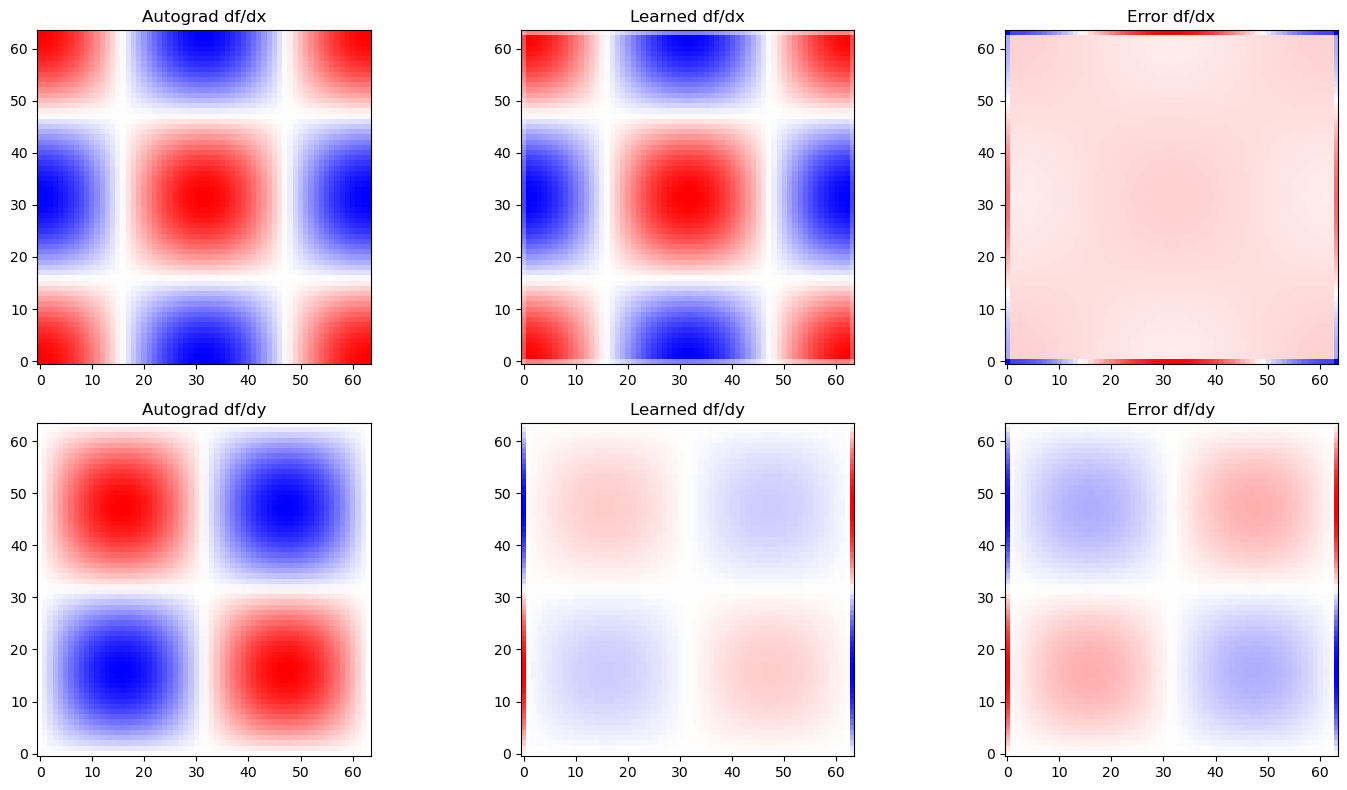

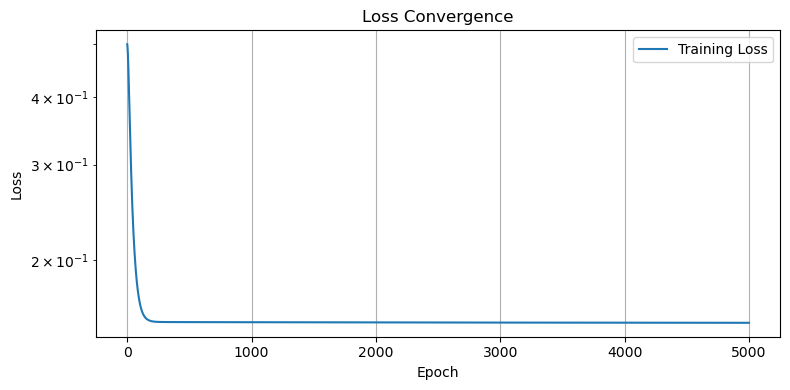

Learned Kx kernel:
 [[-1.4262 -2.3250 -1.4267]
 [ 0.0035 -0.0089  0.0085]
 [ 1.4227  2.3340  1.4182]]
Learned Ky kernel:
 [[-0.6435  0.0067  0.6478]
 [-0.6663 -0.0210  0.6656]
 [-0.6389  0.0144  0.6353]]


In [30]:
# === 8. 可視化 ===
fig, axs = plt.subplots(2,3, figsize=(15,8))

# x 導數
axs[0,0].imshow(grad_x_np, origin='lower', cmap='bwr'); axs[0,0].set_title("Autograd df/dx")
axs[0,1].imshow(fx_learn, origin='lower', cmap='bwr'); axs[0,1].set_title("Learned df/dx")
axs[0,2].imshow(error_x, origin='lower', cmap='bwr'); axs[0,2].set_title("Error df/dx")

# y 導數
axs[1,0].imshow(grad_y_np, origin='lower', cmap='bwr'); axs[1,0].set_title("Autograd df/dy")
axs[1,1].imshow(fy_learn, origin='lower', cmap='bwr'); axs[1,1].set_title("Learned df/dy")
axs[1,2].imshow(error_y, origin='lower', cmap='bwr'); axs[1,2].set_title("Error df/dy")

plt.tight_layout()
plt.show()

# === 8. Loss 收斂曲線 ===
plt.figure(figsize=(8,4))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale("log")
plt.title('Loss Convergence')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# === 9. 查看學到的卷積核 ===
np.set_printoptions(formatter={'float_kind':lambda x: f"{x: .4f}"})

print("Learned Kx kernel:\n", np.array2string(Kx.detach().cpu().numpy().squeeze(), precision=4, floatmode='fixed'))
print("Learned Ky kernel:\n", np.array2string(Ky.detach().cpu().numpy().squeeze(), precision=4, floatmode='fixed'))